In [10]:
import numpy as np
import scipy 
from scipy import stats
from scipy.stats import norm,uniform
import matplotlib.pyplot as plt
import pdb
import seaborn as sns
sns.set()

In [11]:
Power = np.array([36.63, 38.26, 39.39, 40.56, 43.23, 56.54, 72.70, 84.19, 76.06, 61.32, 50.75, 46.90])
Gas = np.array([2.905, 2.81, 2.76, 2.73, 3.20, 3.88, 4.45, 4.8, 4.56, 4.13, 3.68, 3.49])
dt = 1/48
month_list = [i for i in range(1,13)] 
PowerTheta = np.zeros(12)
GasTheta = np.zeros(12)

In [12]:
def func1(N,    #N is the number of periods
    PowerPrices = Power, 
    GasPrices = Gas,
    thetap1= PowerTheta,
    thetag1 = GasTheta,
    rho = 0.3,   
    n = 100000 ,
    random_seed = 100): #number of paths
    
    #params
    N_month = N
    N *= 4
    alphaCC,alphaJC,alphaG = 7, 20, 3
    m = 75
    p = 0.083 # lambda*dt, weekly probability
    CC0,JC0, G0 = 35, 0, 3
    spike_thres = 75
    sigmaG = 7.22/np.sqrt(dt)/100
    
    #V summer and winter
    v_summer = 28.87/np.sqrt(dt)/100
    v_winter = 10.83/np.sqrt(dt)/100
    V = np.zeros((N+1,n))
    
    W = norm.rvs(size = (N+1,n))*np.sqrt(dt)
    Wtilde = norm.rvs(size = (N+1,n))*np.sqrt(dt)
    B = rho*W + np.sqrt(1-rho**2)*Wtilde
    
    CC = np.zeros((N+1,n)) 
    CC[0,:] = CC0
    JC = np.zeros((N+1,n))
    JC[0,:] = JC0
    G = np.zeros((N+1,n)) 
    G[0,:] = G0
    PC = np.zeros((N+1,n))
    PC[0,:] = CC[0,:]
    # 
    Power_MSE,Gas_MSE = 0, 0
    Power_Price_Fit, Gas_Price_Fit, CC_Price_Fit, JC_Price_Fit = list(), list(), list(), list()
    Power_Price_Weekly, Gas_Price_Weekly = list(),list()

    
    for i in range(1, N + 1):
        month1 = month_list[int(np.ceil(i/4)) - 1] if np.ceil(i/4) <= 12 else month_list[int(np.ceil(i/4)) - 1-12]
        monthIndicator = (month1 > 4)&(month1 < 9)

        V[i,:] = monthIndicator*v_summer + (1 - monthIndicator)*v_winter
        CC[i,:] = alphaCC*(thetap1[month1-1] - CC[i-1,:])*dt + V[i,:]*CC[i-1,:]*W[i,:] + CC[i-1,:]
        JC[i,:] = alphaJC*( 0 - JC[i-1,:])*dt + m*(uniform.rvs() < p)+JC[i-1,:]
        #Power Price
        PC[i,:] = CC[i,:] + JC[i,:]*(PC[i-1,:] > spike_thres)
        #Gas Price
        G[i,:]  = alphaG*(thetag1[month1-1] - G[i-1,:])*dt + sigmaG * G[i-1,:] * B[i,:] + G[i-1,:]

        Power_MSE += np.abs(np.mean(PC[i,:]) - PowerPrices[month1 - 1])
        Gas_MSE += np.abs(np.mean(G[i,:]) - GasPrices[month1 - 1])
        
        if i%4 == 0:
            Power_Price_Fit.append(np.mean(PC[i,:]))
            Gas_Price_Fit.append(np.mean(G[i,:]))
            CC_Price_Fit.append(np.mean(CC[i,:]))
            JC_Price_Fit.append(np.mean(JC[i,:]))
            
        Power_Price_Weekly.append(PC[i,:])
        Gas_Price_Weekly.append(G[i,:])
        
    np.savetxt("power_price_new.csv", np.array(Power_Price_Weekly), delimiter=",") 
    np.savetxt("gas_price_new.csv",np.array(Gas_Price_Weekly),delimiter=",")
    return Power_MSE, Gas_MSE,(np.array(Power_Price_Weekly),np.array(Gas_Price_Weekly),\
           Power_Price_Fit,Gas_Price_Fit,CC_Price_Fit,JC_Price_Fit)
    

In [13]:
def cali(MSE_fun, N, thetap_l = 0, thetap_r = 300, thetap_d = 0.5, thetag_l = 0, thetag_r = 10, thetag_d = 0.05):
    MSE_p, MSE_g = list(), list()
    thetap_list = [thetap_l + thetap_d * x for x in range(int((thetap_r -thetap_l)/thetap_d)+1)]
    thetag_list = [thetag_l + thetag_d * x for x in range(int((thetag_r - thetag_l)/thetag_d)+1)]
    for i1 in thetap_list:
        PowerTheta[N - 1] = i1
        MSE_p.append(MSE_fun(N, Power,Gas,thetap1= PowerTheta, thetag1 = GasTheta,rho = 0.3,n = 100)[0])
        #print("MSE_P:", MSE_p)
        #print(PowerTheta)
    for i2 in thetag_list:
        GasTheta[N - 1] = i2
        MSE_g.append(MSE_fun(N, Power,Gas,thetap1= PowerTheta,thetag1 = GasTheta,rho = 0.3,n = 100)[1])
    #print('MSE\n',MSE_p)
    #print('index\n',np.argmin(MSE_p))
    #print('thetap\n',thetap_list[np.argmin(MSE_p)])
    return thetap_list[np.argmin(MSE_p)], thetag_list[np.argmin(MSE_g)], np.min(MSE_p), np.min(MSE_g)
    

In [14]:
np.random.seed(10)
PowerTheta = np.zeros(12)
GasTheta = np.zeros(12)
for n in range(1, 13):
    print("This is the", n ,"for loop")
    PowerTheta[n-1],GasTheta[n-1],MSE_P,MSE_G  = cali(func1, N = n)
    print(PowerTheta)
    print(GasTheta)
    print(MSE_P)
    print(MSE_G)

This is the 1 for loop
[40.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[2.55 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
1.114855970944923
0.11578865205000888
This is the 2 for loop
[40.  41.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[2.55 2.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
2.8746539424393944
0.2594789793919041
This is the 3 for loop
[40.  41.5 41.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[2.55 2.8  2.65 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
5.776167317584573
0.2273108124487404
This is the 4 for loop
[40.  41.5 41.  40.5  0.   0.   0.   0.   0.   0.   0.   0. ]
[2.55 2.8  2.65 2.15 0.   0.   0.   0.   0.   0.   0.   0.  ]
7.888740182802728
0.36135799512548594
This is the 5 for loop
[40.  41.5 41.  40.5 37.5  0.   0.   0.   0.   0.   0.   0. ]
[2.55 2.8  2.65 2.15 5.65 0.   0.   0.   0.   0.   0.   0.  ]
8.679551404151617
1.2257908916223736
This is the 6 for loop
[40.  41.5 41.  40.5 37.5 75.   0.   0.   0.   0.   0.   0. ]
[2.5

In [16]:
result = func1(12, Power,Gas,thetap1= PowerTheta, thetag1 = GasTheta,rho = 0.3,n = 100)

Power_Price_Fit,Gas_Price_Fit,CC_Price_Fit,JC_Price_Fit = result[2]

fig = plt.figure()
plt.plot(Power_Price_Fit,label = 'Fitted Power Price')
plt.plot(Power,label = 'Real Power Price')
plt.plot(CC_Price_Fit,label = 'CC Price',linestyle = "dotted")
plt.plot(JC_Price_Fit,label = 'JC Price',linestyle = "dotted")
plt.title('Power Price Plot')
plt.legend()

fig = plt.figure()
plt.plot(Gas_Price_Fit,label = 'Fitted Gas Price')
plt.plot(Gas,label = 'Real Gas Prices')
plt.title('Gas Price Plot')
plt.legend()

print('Power Price Fit: ',Power_Price_Fit,'\n')
print('CC Price Fit: ',CC_Price_Fit,'\n')
print('JC_Price_Fit: ',JC_Price_Fit,'\n')
print('real Power Price: ', Power,'\n')
print('Gas_Price_Fit: ',Gas_Price_Fit,'\n')
print('Gas Prices: ',Gas,'\n')

ValueError: too many values to unpack (expected 4)

In [17]:
P_theta = np.array([40, 41.5, 41, 40.5, 37.5, 75,  55,  95,  72,  44,  35.5, 28.5 ])
G_theta = np.array([2.55, 2.8,  2.65, 2.15, 5.65, 5.2,  6.25, 7.3,  2.55, 2.55, 2.4,  2.05])

T = np.arange(1,13)





In [18]:
print()

Text(0.5, 1.0, 'Calibrated Theta for Gas Process')

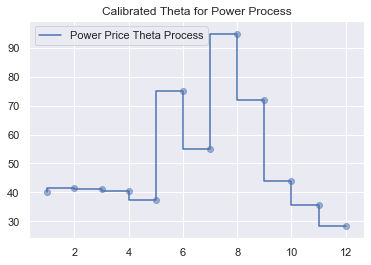

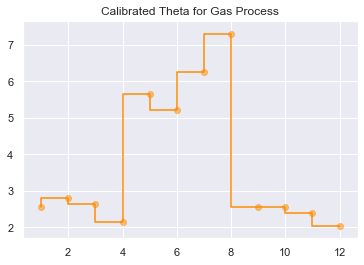

In [19]:
plt.step(T, P_theta, label='Power Price Theta Process')
plt.scatter(T, P_theta,  alpha=0.5)

plt.legend()
plt.title('Calibrated Theta for Power Process')

plt.figure()
plt.step(T, G_theta, label='Gas Price Theta Process',color = 'darkorange')
plt.scatter(T, G_theta, alpha=0.5,color = 'darkorange')
plt.title('Calibrated Theta for Gas Process')

In [20]:
result = func1(24, thetap1= P_theta, thetag1 = G_theta) #number of paths

P_price = np.mean(result[2].reshape(96,100,1000),axis = 1)
G_price = np.mean(result[3].reshape(96,100,1000),axis = 1)
SS_price = (P_price - 12*G_price)#*1000 * 16 * 7.6

power_mean = np.mean(P_price,axis = 1)
power_std = np.std(P_price,axis = 1)
power_upper = power_mean + 1.96*power_std
power_lower = power_mean - 1.96*power_std

gas_mean = np.mean(G_price,axis = 1)
gas_std = np.std(G_price,axis = 1)
gas_upper = gas_mean + 1.96*gas_std
gas_lower = gas_mean - 1.96*gas_std

ss_mean = np.mean(SS_price, axis = 1)
ss_std = np.std(SS_price, axis = 1)
ss_upper = ss_mean + 1.96*ss_std
ss_lower = ss_mean - 1.96*ss_std

weekly = np.arange(1,97)
fig = plt.figure()
ax = plt.gca()
ax.plot(weekly,power_mean,label = 'mean power price')
ax.fill_between(weekly, power_lower, power_upper,color = 'lightblue',label = '95% confidence interval')
ax.set_title('95% confidence interval for weekly power prices')
ax.set_xlabel('week')
ax.set_ylabel('price')
ax.legend()

fig = plt.figure()
ax = plt.gca()
ax.plot(weekly,gas_mean,label = 'mean gas price',color = 'darkorange')
ax.fill_between(weekly, gas_lower, gas_upper,color = 'bisque',label = '95% confidence interval')
ax.set_title('95% confidence interval for weekly gas prices')
ax.set_xlabel('week')
ax.set_ylabel('price')
ax.legend()




AttributeError: 'tuple' object has no attribute 'reshape'

NameError: name 'weekly' is not defined

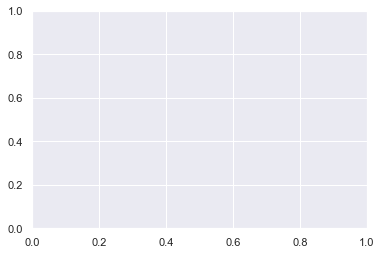

In [21]:
fig = plt.figure()
ax = plt.gca()
ax.plot(weekly,ss_mean,label = 'mean spark spread',color = 'darkslategrey')
ax.fill_between(weekly, ss_lower, ss_upper,color = 'paleturquoise',label = '95% confidence interval')
ax.set_title('95% confidence interval for weekly spark spread')
ax.set_xlabel('week')
ax.set_ylabel('price')
ax.legend()

(96,)